## Import Libraries

In [ ]:
# Import necessary libraries for data handling, computation, visualization, and clustering

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import utm
import matplotlib.ticker as ticker
from itertools import groupby
import os, os.path
import seaborn as sns
from datetime import datetime
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score

## Entropy Calculation Function

In [2]:
# Define a function to calculate entropy based on location frequency
def calculate_entropy(freq):
    # Initialize probability list and calculate the sum of all frequencies
    Probabilities = []
    sum_of_all_freq = sum(freq)

    # Calculate the probability for each location
    for count in freq:
        Prob = count / sum_of_all_freq
        Probabilities.append(Prob)
    
    # Compute entropy using the probability distribution
    entropy_of_loc = -np.sum(Probabilities * np.log2(Probabilities))
    return entropy_of_loc

## Loading the Dataset

In [3]:
# Load the GPS trajectory data for a specific user (User_087)
# This dataset includes 'Latitude', 'Longitude', and 'Time' columns for each data point
filename = 'User_087_latlontime.csv'
df = pd.read_csv(filename, encoding='utf-8')
df = df.iloc[: , 1:]
# represent points consistently as (Latitude, Longitude)
coords = df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = df['Time'].values.tolist()

In [4]:
print('Total points: ',len(coords))

Total points:  144


In [5]:
#Finding minimum and maximum points from user data
lats_index_min = np.argmin(lats_xy)
lats_index_max = np.argmax(lats_xy)
longs_index_min = np.argmin(longs_xy)
longs_index_max = np.argmax(longs_xy)

#Defining the boundary points
p1_xy = (longs_xy[longs_index_min],lats_xy[lats_index_min])
p2_xy = (longs_xy[longs_index_min],lats_xy[lats_index_max])
p3_xy = (longs_xy[longs_index_max],lats_xy[lats_index_min])
p4_xy = (longs_xy[longs_index_max],lats_xy[lats_index_max])

## Data Preprocessing

In [6]:
scaler = MinMaxScaler()
model=scaler.fit(df)
scaled_data=model.transform(df)
normalized_data = pd.DataFrame(scaled_data, columns = ['Latitude','Longitude','Time'])

In [7]:
# Setting value of epsilon for clustering
epsilon = 0.1

## Implementing EDDBSCAN

In [8]:
# To find minPoints using merge-sort algorithm
l=1
r=len(coords)
v=[]
w=[]
def divide(l, r):
    if l<r:
        m = l+(r-l)//2
        try:
            sil_score, num_clusters = cal(m, epsilon)
            if sil_score not in v and num_clusters>0:
                v.append(sil_score)
                w.append(m)
                divide(l, m)
        except ValueError:
            divide(l, m)
    else:
        return
def cal(m,epsilon):
    db = DBSCAN(eps=epsilon, min_samples=m, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
    sil_score = metrics.silhouette_score(normalized_data, db.labels_)
    num_clusters = len(set(db.labels_)) #- (1 if -1 in db.labels_ else 0)
    return [sil_score, num_clusters]
divide(l,r)
max_i = max(v)
max_i_index = v.index(max_i)
min_point = w[max_i_index]

In [9]:
db = DBSCAN(eps=epsilon, min_samples=min_point, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

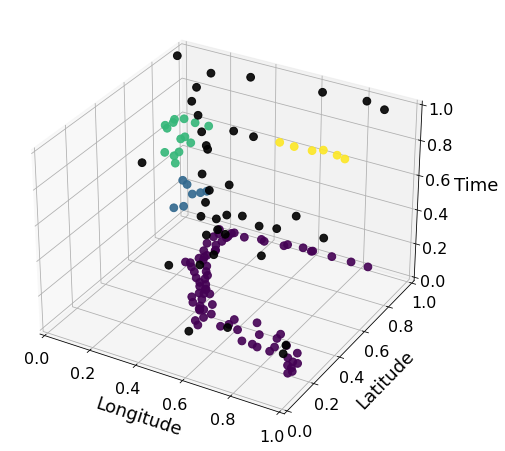

In [10]:
to_plot=normalized_data
to_plot.loc[:,'Label']=db.labels_
noise_points = to_plot[to_plot.Label==-1]
to_plot=to_plot[to_plot.Label!=-1]
#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9, s=60)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise', s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
#first_legend = ax.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=4, frameon=True)
#plt.gca().add_artist(first_legend)
#plt.legend(loc='upper left')
plt.show()

In [11]:
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(normalized_data, cluster_labels)))

Silhouette coefficient: 0.649


In [12]:
print(num_clusters)

5


In [13]:
print('Davies-Bouldin score: {:0.03f}'.format(davies_bouldin_score(normalized_data, cluster_labels)))

Davies-Bouldin score: 0.422


### Calculation of Entropy after each recorded GPS point

### Mapping of points in a 3D space-time grid and calculate entropy after addition of each new point

In [14]:
#Initialize values to partition along number of grids n each axis
x=10
y=10
z=24

In [15]:
X = np.linspace((longs_xy[longs_index_min]),(longs_xy[longs_index_max]),x)
Y = np.linspace((lats_xy[lats_index_min]),(lats_xy[lats_index_max]), y)
Z = np.linspace(0,z,z)
d=1
grids_index = np.zeros((10,10,24))
point_count_inside_grid = np.zeros((1,2400))
counting = np.zeros((1,2400))
found_grid_index = []
allover_entropy=[]

for t in range(24):
    for yax in range(10):
        for xax in range(10):
            grids_index[xax,yax,t]=d
            d=d+1
            

for user in range(len(coords)):
    p_lat = lats_xy[user]
    p_long = longs_xy[user]
    p_time = user_time[user]
    for t in range(24):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(10):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(10):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            found_grid_index.append(int(found_at))
    frequency_of_grids = [len(list(group)) for key, group in groupby(found_grid_index)]
    current_entropy = calculate_entropy(frequency_of_grids)
    allover_entropy.append(current_entropy)

### Find points that can be transmitted directly

In [16]:
threshold = 1
delta_1 = 0/100

In [17]:
max_limit = (threshold/100)*len(coords) 
new_data = []
scaled_points = []
for temp in range(len(allover_entropy)-1):
    if allover_entropy[temp] != 0:
        percent_change = ((allover_entropy[temp+1]-allover_entropy[temp])/allover_entropy[temp])*100
        if percent_change > delta_1:
            new_data.append(df.iloc[temp].tolist())
            scaled_points.append(scaled_data[temp].tolist())

In [18]:
direct_points = len(new_data)
print('Directly transmitted points: ',len(new_data))

Directly transmitted points:  127


In [19]:
new_df = pd.DataFrame(new_data, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(scaled_points, columns = ['Latitude','Longitude','Time'])

In [20]:
coords = new_df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = new_df['Time'].values.tolist()
point_count_inside_grid = np.zeros((1,2400))
counting = np.zeros((1,2400))
found_grid_index = []
d=1
new_points = []
new_scaled_points = []

In [21]:
# Store maximum of 1% points in a grid
for user in range(len(coords)):
    p_lat = lats_xy[user]
    p_long = longs_xy[user]
    p_time = user_time[user]
    for t in range(24):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(10):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(10):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            point_count_inside_grid[:,int(found_at)] += 1
                            if point_count_inside_grid[:,int(found_at)] <= max_limit:
                                new_points.append(new_df.iloc[user].tolist())
                                new_scaled_points.append(normalized_data.iloc[user].tolist())

In [22]:
new_df = pd.DataFrame(new_points, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(new_scaled_points, columns = ['Latitude','Longitude','Time'])

### Plot directly transmitted normalized data points

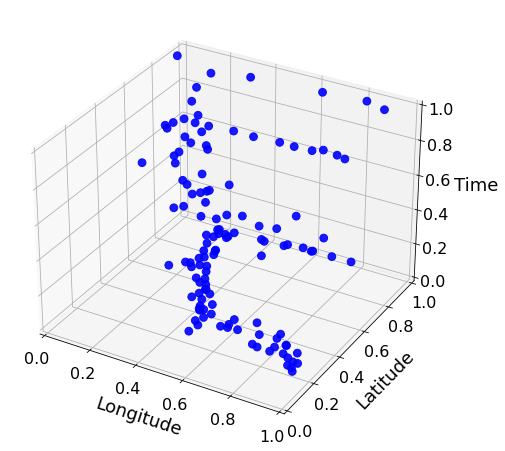

In [23]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(normalized_data['Longitude'], normalized_data['Latitude'], normalized_data['Time'],color='blue',alpha=0.9, s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
plt.show()

### Clustering of directly transmitted data points

In [24]:

# To find minPoints using merge-sort algorithm
l=1
r=len(normalized_data)
v=[]
w=[]
def divide(l, r):
    if l<r:
        m = l+(r-l)//2
        try:
            sil_score, num_clusters = cal(m, epsilon)
            if sil_score not in v and num_clusters>0:
                v.append(sil_score)
                w.append(m)
                divide(l, m)
        except ValueError:
            divide(l, m)
    else:
        return
def cal(m,epsilon):
    db = DBSCAN(eps=epsilon, min_samples=m, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
    num_clusters = len(set(db.labels_)) #- (1 if -1 in db.labels_ else 0)
    sil_score = metrics.silhouette_score(normalized_data, db.labels_)
    return [sil_score, num_clusters]
divide(l,r)
max_i = max(v)
max_i_index = v.index(max_i)
min_point = w[max_i_index]

In [25]:
#db = DBSCAN(eps=epsilon, min_samples=min_point, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
db = DBSCAN(eps=epsilon, min_samples=min_point, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

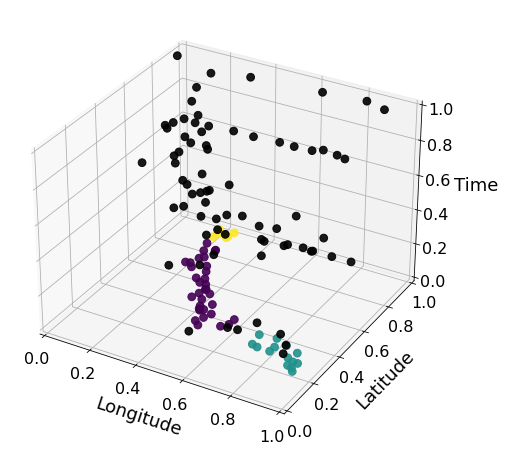

In [26]:
to_plot=normalized_data
to_plot.loc[:,'Label']=db.labels_
noise_points = to_plot[to_plot.Label==-1]
to_plot=to_plot[to_plot.Label!=-1]
#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9, s=60)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise', s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
#first_legend = ax.legend(loc='upper left')
#plt.gca().add_artist(first_legend)
#plt.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=5, frameon=True)
plt.show()

In [27]:
print(num_clusters)

4


In [28]:
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(normalized_data, cluster_labels)))

Silhouette coefficient: 0.623


In [29]:
print(davies_bouldin_score(normalized_data, cluster_labels))

0.39419809917444587
